(4905.82875149675, 4377.0, 1863.3382276699708)
 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  910.1804340489559 ... 1.8364742917890597  -0.6599621329389229
  2  960.0245184732191 ...  1.881073372568108  -0.6860143395936242
  3  597.8152168592918 ... 1.1385373093702218 -0.14086816706196403
  4  973.6667245816213 ... 1.1874304293647753 -0.18652043515683936
  5  837.1660022684383 ... 1.9823658868000895  -0.7429595390373547
  6   675.903022932795 ... 1.5378024183363501  -0.4672513488415334
  7  604.0767325064718 ... 1.2017260106181333 -0.19951365327556775
  8   919.950704017256 ... 1.7528767125368079  -0.6093784283578949
  9  792.9578136204907 ... 1.5557008727159602 -0.47981523835427914
 10 1469.3509294137773 ... 1.3441131101992205 -0.32108954282948304
...                ... ...                ...                  ...
355 1086.0198318905148 ... 1.4984360626298618 -0.43909554147835905
356 1081.929385

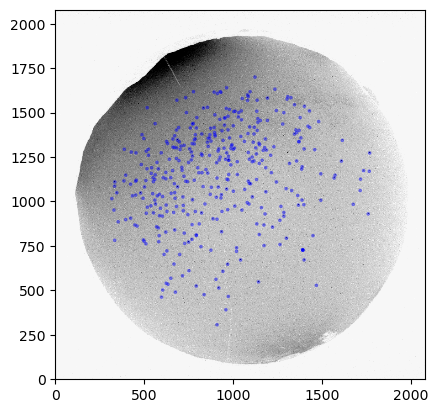

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder

from cloud_to_data import Mask

mask = Mask()
mask_data = mask.data
t = mask_data == 0
mask_data = t

# 读取图像
datafits = fits.open("ossaf/data/2023_05_23__00_24_04.fits.bz2")[0]
data = datafits.data[0]
gain = datafits.header['GAIN_ELE']
# data = data / 1e6


mean, median, std = sigma_clipped_stats(data, mask=mask_data, sigma=3.0)
print((mean, median, std))

# 创建DAOStarFinder对象
daofind = DAOStarFinder(fwhm=3.0, threshold=5. * std)

# 提取点源
sources = daofind.find_stars(data - median, mask=mask_data)

# 打印点源坐标和其他属性
print(sources)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)



(4053.812426453283, 3530.0, 2111.294826161956)
 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  709.9290263309745 ... 1.3555143165707992  -0.3302602721001201
  2 1373.1796194070985 ... 1.1690865460116784 -0.16961665657018887
  3 1067.2733490466028 ...  1.596697547903992  -0.5080566458310978
  4 1466.1576327391056 ...  1.053433322315442 -0.05651762972052703
  5 1233.9251789484815 ... 2.2004556886348636  -0.8562815686083204


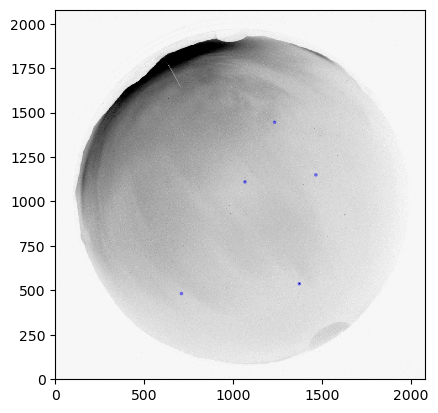

In [11]:
datafits = fits.open("ossaf/data/2023_05_27__01_19_08.fits.bz2")[0]
# 读取图像
data = datafits.data[0]
gain = datafits.header['GAIN_ELE']
# data = data / 1e6


mean, median, std = sigma_clipped_stats(data, mask=mask_data, sigma=3.0)
print((mean, median, std))

# 创建DAOStarFinder对象
daofind = DAOStarFinder(fwhm=3.0, threshold=5. * std)

# 提取点源
sources = daofind.find_stars(data - median, mask=mask_data)

# 打印点源坐标和其他属性
print(sources)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)



In [12]:
# 像素坐标系到地平坐标系的映射
from astropy import units as u
from astropy.coordinates import SkyCoord, AltAz, EarthLocation
from astropy.time import Time

mask.center.x

1053

In [13]:
mask.center.y

1017

In [14]:
sources[0]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64
1,709.9290263309745,481.96602640860203,0.7131505785972467,-0.021327215572564565,0.008771413698014353,25,0.0,17071.0,1.3555143165707992,-0.3302602721001201


In [33]:
def to_altaz(x, y, x_offset=1053, y_offset=1017, radius=983, north=155.6 * u.deg):
    # move to center
    x = x - 1053
    y = y - 1017

    # polar coordinates
    r = np.sqrt(x ** 2 + y ** 2)
    theta = np.arctan2(y, x)
    print(f"theta: {theta}, r: {r}")

    # convert to altaz
    alt = r / radius * u.rad * np.pi / 2
    alt = np.pi / 2 * u.rad - alt
    az = (- theta) * u.rad - north
    print(f"alt: {alt}, az: {az}")

    return AltAz(alt=alt, az=az)

In [34]:
to_altaz(1100, 1017)

theta: 0.0, r: 47.0
alt: 1.4956921280569921 rad, az: -2.7157323161031766 rad


<AltAz Coordinate (obstime=None, location=None, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (204.4, 85.69684639)>

In [35]:
star = to_altaz(sources[1]['xcentroid'], sources[1]['ycentroid'])
star

theta: -0.9825335951961254, r: 576.9869013719941
alt: 0.6487933712670251 rad, az: -1.7331987209070512 rad


<AltAz Coordinate (obstime=None, location=None, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (260.69502823, 37.17312195)>

In [36]:
location = EarthLocation(lat=43.82416667 * u.deg, lon=126.331111 * u.deg, height=313 * u.m)

In [37]:
time = datafits.header['DATE-OBS']
time = Time(time, format='isot', scale='utc', location=location)
time

<Time object: scale='utc' format='isot' value=2023-05-27T01:18:05.066>

In [38]:
time = time - 8 * u.hour

In [39]:
time

<Time object: scale='utc' format='isot' value=2023-05-26T17:18:05.066>

In [40]:
frame = AltAz(obstime=time, location=location)
star = SkyCoord(alt=star.alt, az=star.az, frame=frame)

In [41]:
star.transform_to('icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (213.3286361, 19.10110326)>

In [42]:
print(star.transform_to('icrs'))

<SkyCoord (ICRS): (ra, dec) in deg
    (213.3286361, 19.10110326)>


In [43]:
tstar = star.transform_to('icrs')
tstar.to_string('hmsdms')

'14h13m18.87266387s +19d06m03.9717186s'

In [44]:
star.to_string('dms')

'260d41m42.10164439s 37d10m23.23901879s'